In [80]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

batchSize = 5

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

class Encoder(nn.Module):    # input image 1(batch)x120x80
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # batch x 16 x 120 x 80
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 120 x 80
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 120 x 80
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2,2) # batch x 64 x 60 x 40
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), #batch x 128 x 60 x 40
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,3,padding=1),  #batch x 256 x 30 x 20
            nn.ReLU()
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batchSize,-1)   # batch = 1
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,2,1,1), # batch x 128 x 60 x 40
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128,64,3,1,1),    # batch x 64 x 60 x 40
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64,16,3,1,1),   # batch x 16 x 60 x 40
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16,1,3,2,1,1),   # batch x 1 x 120 x 80
            nn.ReLU()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        out = x.view(batchSize,256,30,20)
        out = self.layer1(out)
        out = self.layer2(out)
        return out



In [ ]:
NUM_EPOCH = 50
learning_rate = 0.00015

bCuda = 1
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

transformClean = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

transformNoise = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    AddGaussianNoise(0,0.001*np.random.randint(1,4))
])

# for training
traindata = np.load('train.npy')
traindataset = numpyDataset(traindata, transformClean)
trainloaderClean = DataLoader(traindataset, batch_size=batchSize, shuffle=False, num_workers=0)

traindataset = numpyDataset(traindata, transformNoise)
trainloaderNoise = DataLoader(traindataset, batch_size=batchSize, shuffle=False, num_workers=0)

cleanTrainLabel = []
for batch_idx, data in enumerate(trainloaderClean):
    data = Variable(data).cuda()
    cleanTrainLabel.append(data)

encoder = Encoder()
decoder = Decoder()

if bCuda:
    encoder.cuda()
    decoder.cuda()

loss_func = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

plotdata_loss = []
plotdata_std = []
eplist = []
for epoch in range(NUM_EPOCH):
    eplist.append(epoch)
    loss_train = []
    for batch_idx, data in enumerate(trainloaderNoise):
        data = Variable(data).cuda()

        optimizer.zero_grad()
        output = encoder.forward(data)
        output = decoder.forward(output)

        #loss = loss_func(output, data)  # output image  <-> ground truth (input image)
        loss = loss_func(output, cleanTrainLabel[batch_idx])
        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item()
        loss_train.append(loss_train_batch)
        #if batch_idx % 110 == 0:
        #    print("[epoch %d] [batch_index %3d] loss: (training) %f"%(epoch,batch_idx,loss_train_batch))
        #del data

    loss_train_meant = np.mean(loss_train)
    loss_train_std = np.std(loss_train)

    plotdata_loss.append(loss_train_batch)
    plotdata_std.append(loss_train_std)
    print("[epoch %d] loss: (training) %f" % (epoch, loss_train_meant))

[epoch 0] loss: (training) 0.051464
[epoch 1] loss: (training) 0.025076
[epoch 2] loss: (training) 0.022445
[epoch 3] loss: (training) 0.019055
[epoch 4] loss: (training) 0.014940
[epoch 5] loss: (training) 0.008780
[epoch 6] loss: (training) 0.007450
[epoch 7] loss: (training) 0.006946
[epoch 8] loss: (training) 0.006033
[epoch 9] loss: (training) 0.005537
[epoch 10] loss: (training) 0.005431
[epoch 11] loss: (training) 0.004773
[epoch 12] loss: (training) 0.004465
[epoch 13] loss: (training) 0.004273
[epoch 14] loss: (training) 0.004049
[epoch 15] loss: (training) 0.004176
[epoch 16] loss: (training) 0.003851
[epoch 17] loss: (training) 0.003352
[epoch 18] loss: (training) 0.003291
[epoch 19] loss: (training) 0.003202


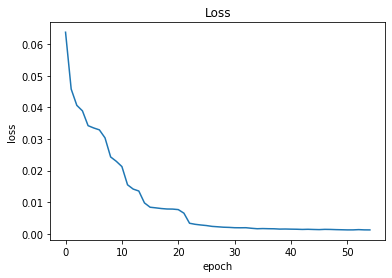

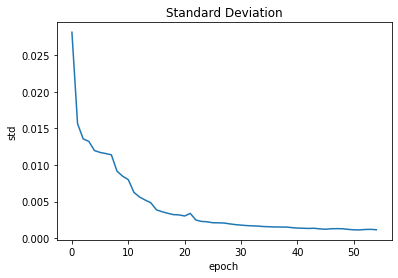

In [73]:
plt.plot(eplist, plotdata_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

plt.plot(eplist, plotdata_std)
plt.xlabel('epoch')
plt.ylabel('std')
plt.title('Standard Deviation')
plt.show()

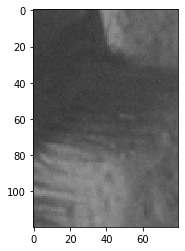

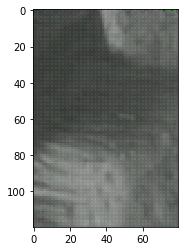

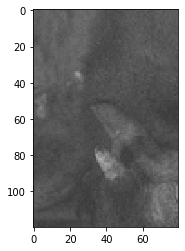

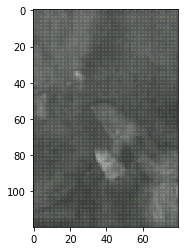

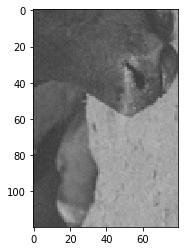

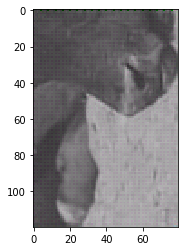

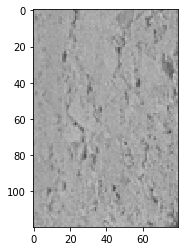

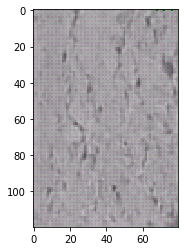

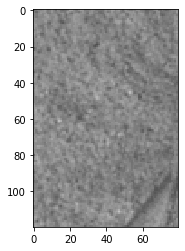

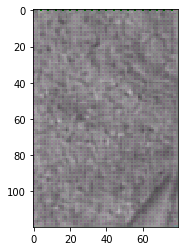

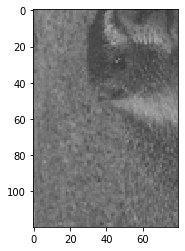

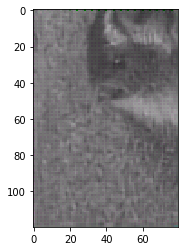

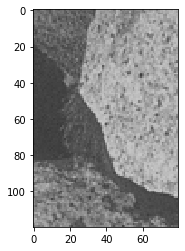

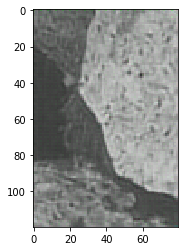

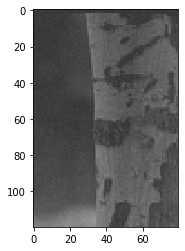

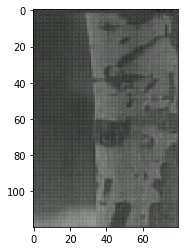

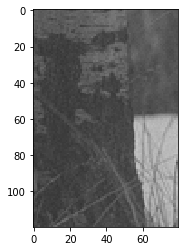

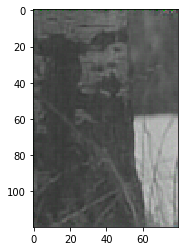

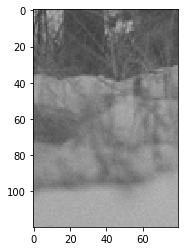

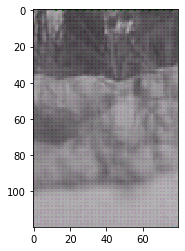

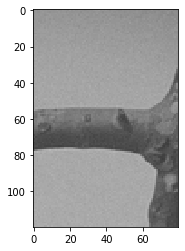

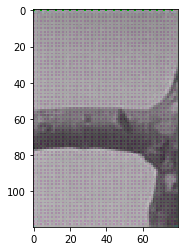

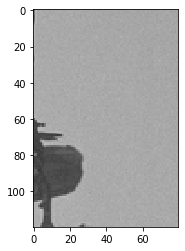

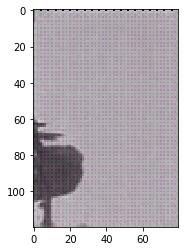

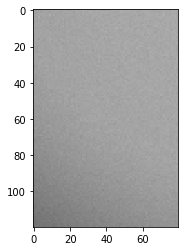

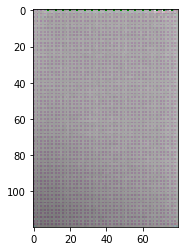

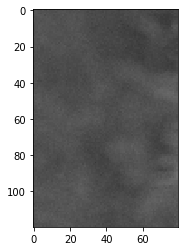

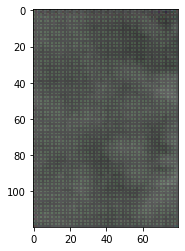

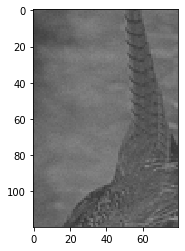

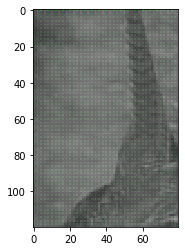

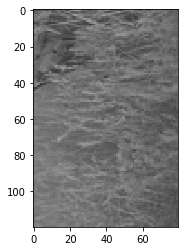

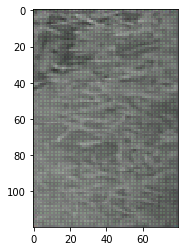

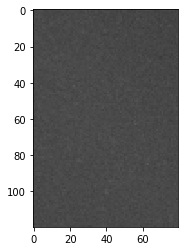

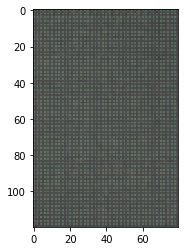

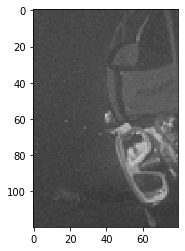

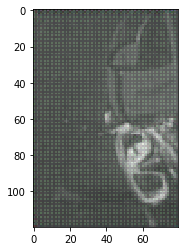

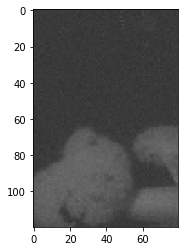

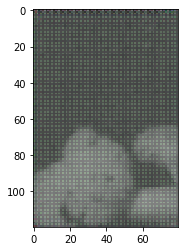

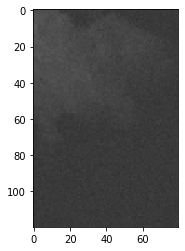

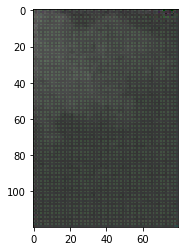

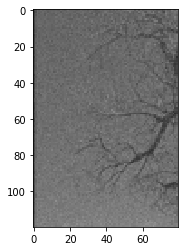

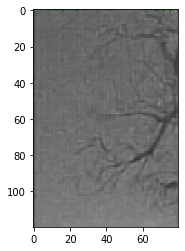

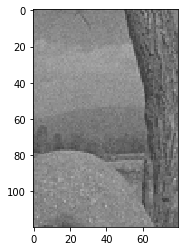

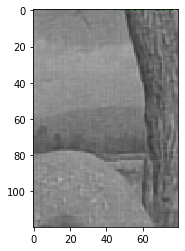

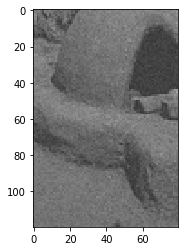

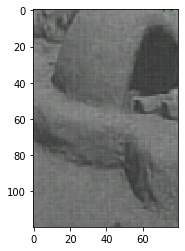

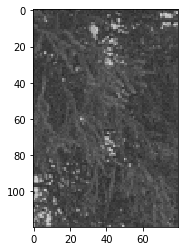

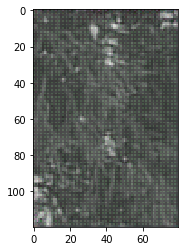

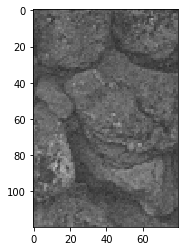

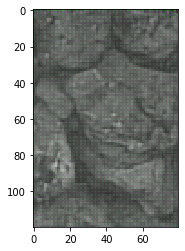

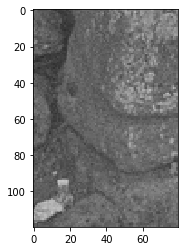

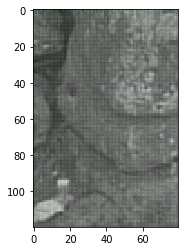

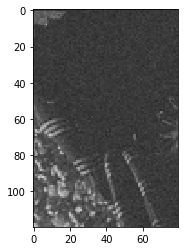

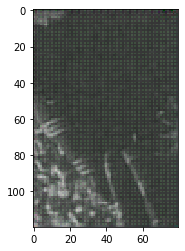

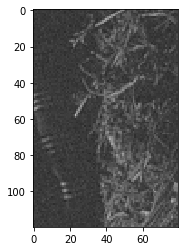

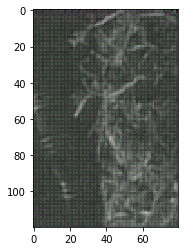

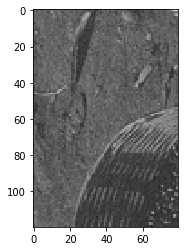

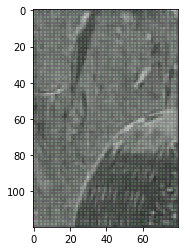

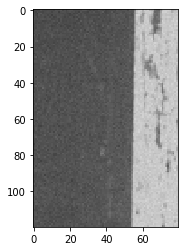

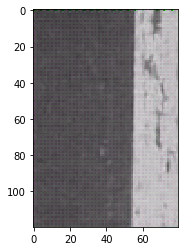

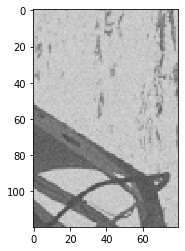

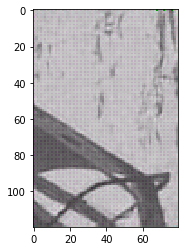

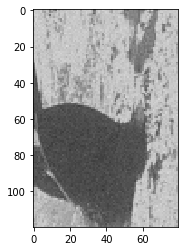

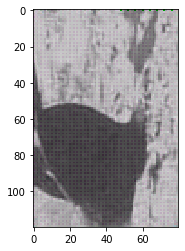

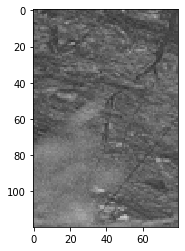

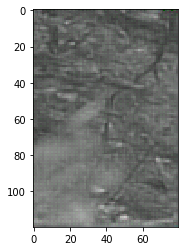

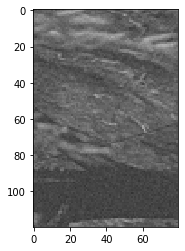

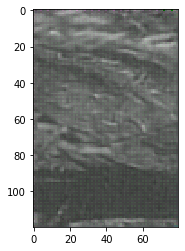

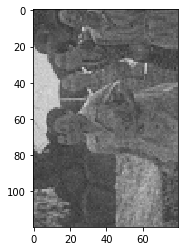

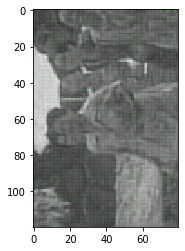

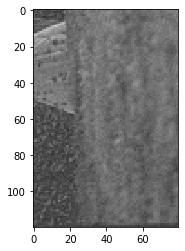

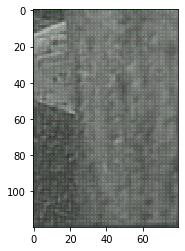

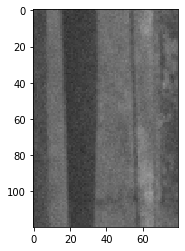

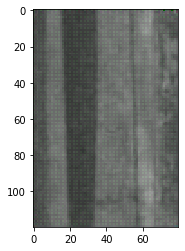

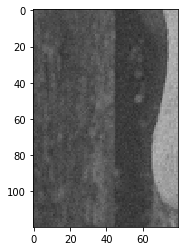

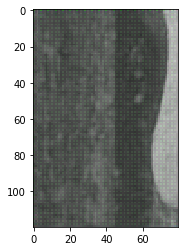

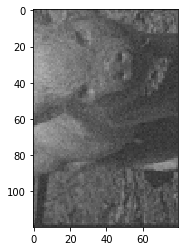

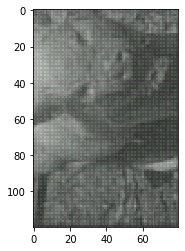

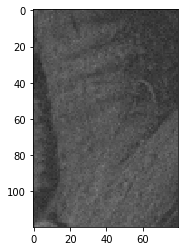

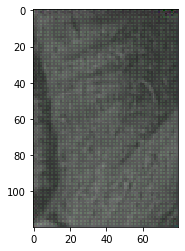

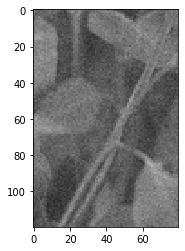

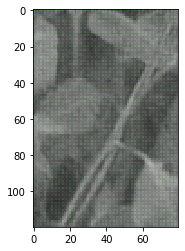

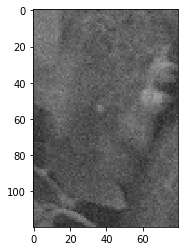

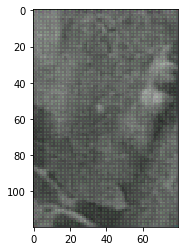

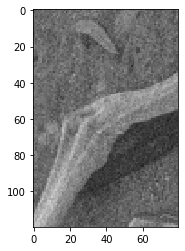

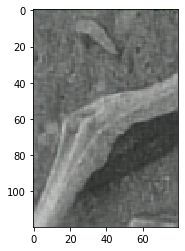

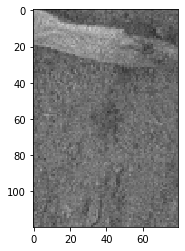

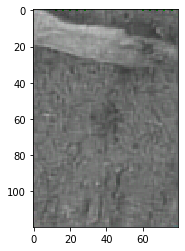

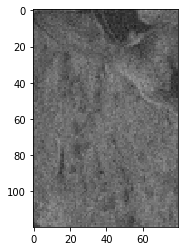

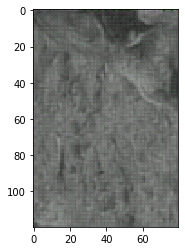

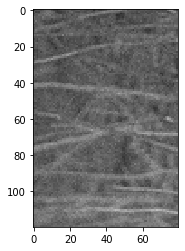

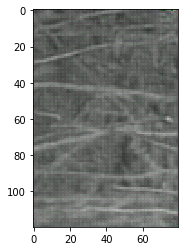

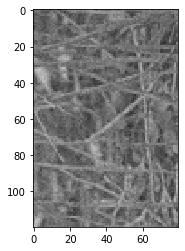

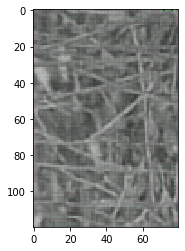

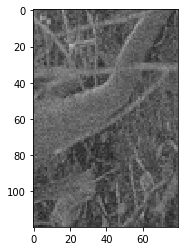

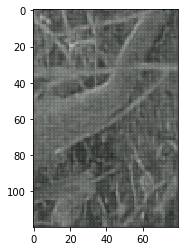

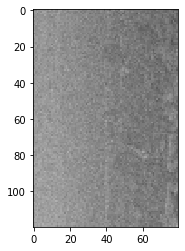

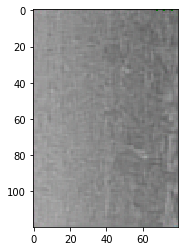

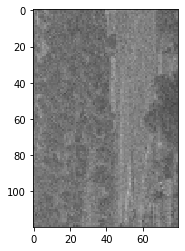

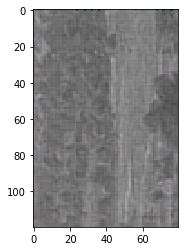

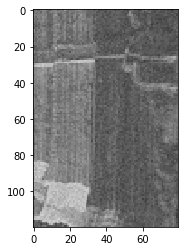

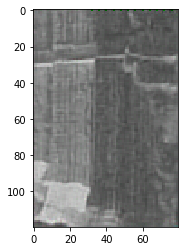

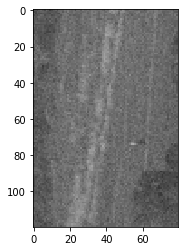

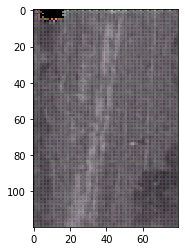

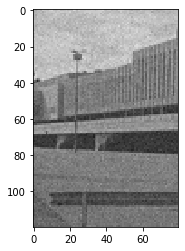

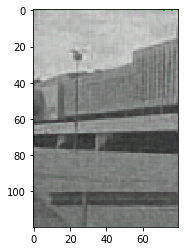

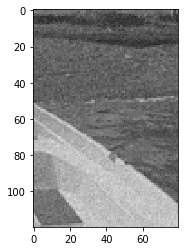

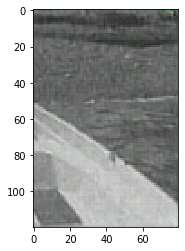

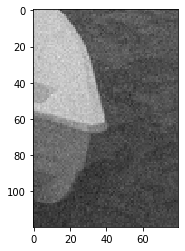

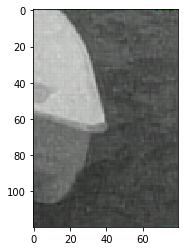

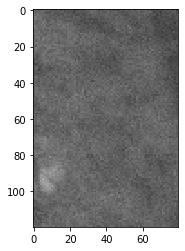

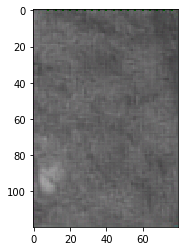

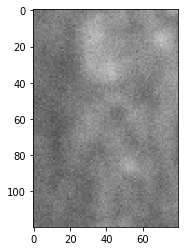

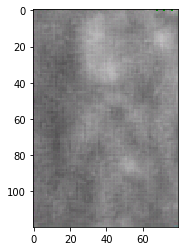

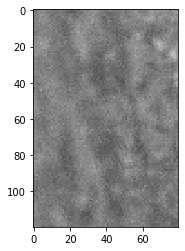

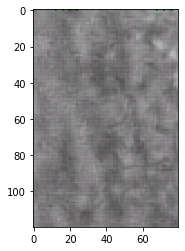

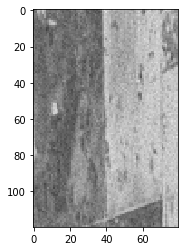

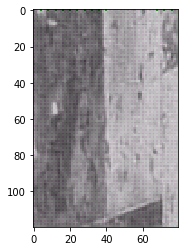

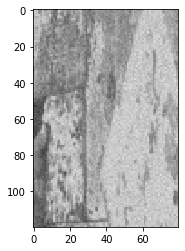

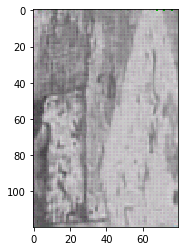

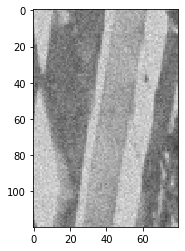

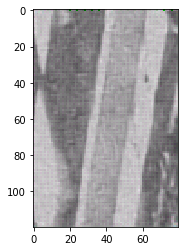

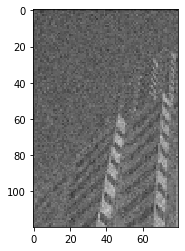

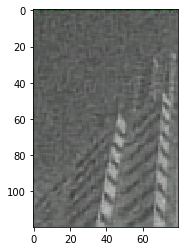

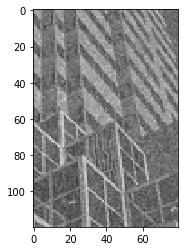

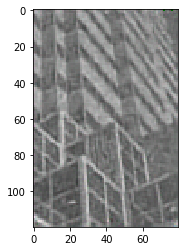

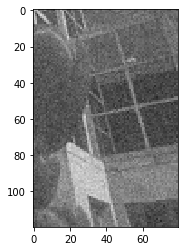

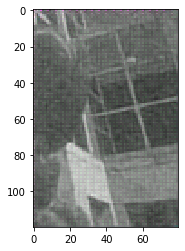

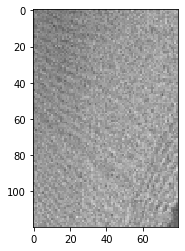

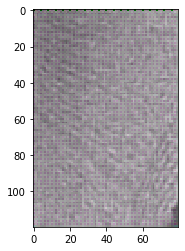

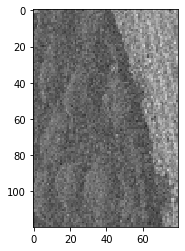

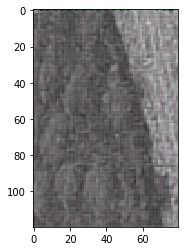

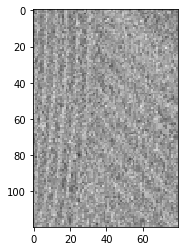

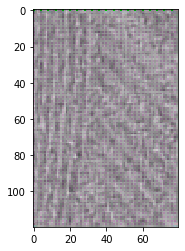

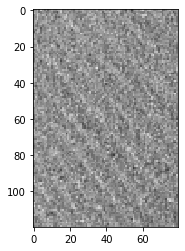

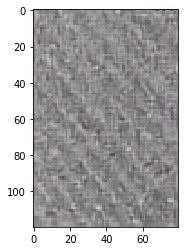

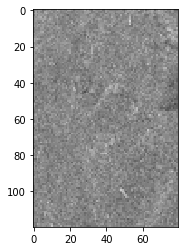

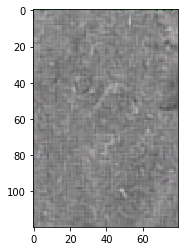

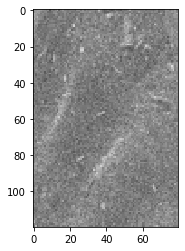

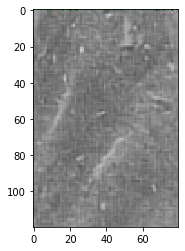

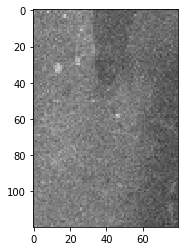

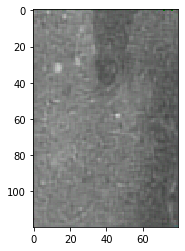

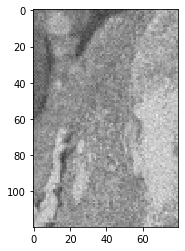

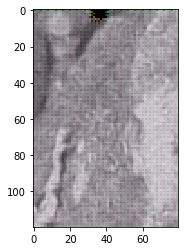

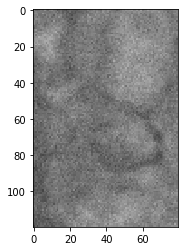

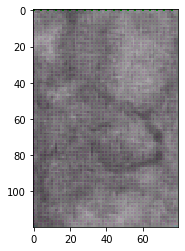

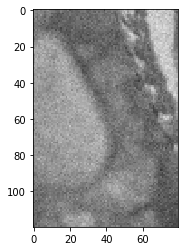

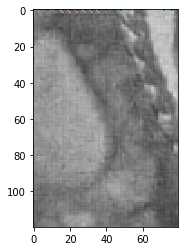

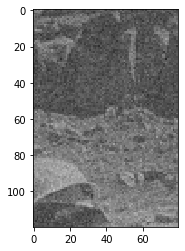

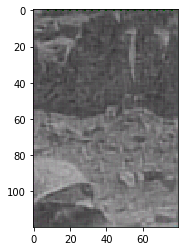

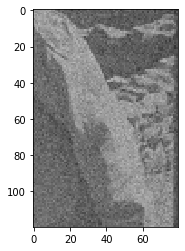

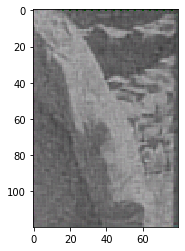

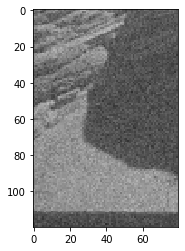

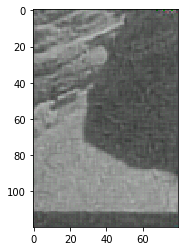

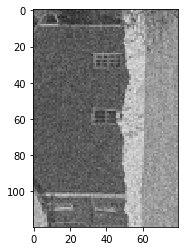

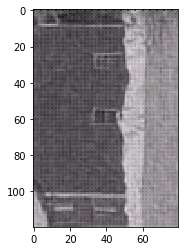

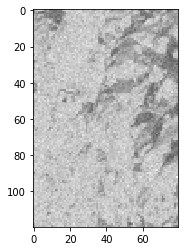

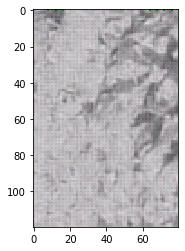

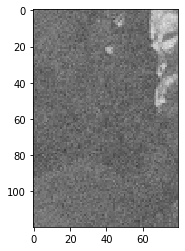

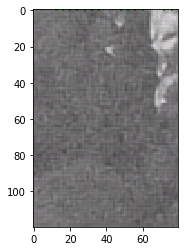

In [74]:
# for testing
testdata = np.load('test.npy')
testdataset = numpyDataset(testdata, transformClean)
testloader = DataLoader(testdataset, batch_size=batchSize, shuffle=False, num_workers=0)

result_for_submit = None  # this is for submit file

for batch_idx, data in enumerate(testloader):
    #data = Variable(data).cuda()
    image = data[0]
    to_img = transforms.ToPILImage()
    image = to_img(image)
    fig = plt.imshow(image)
    plt.show()
    
    
    output = encoder.cpu().forward(data)
    output = decoder.cpu().forward(output)
    result_of_test = output
    
    image = output[0]
    to_img = transforms.ToPILImage()
    image = to_img(image)
    fig = plt.imshow(image)
    plt.show()